<div align="center"><a href="https://colab.research.google.com/github/institutohumai/cursos-python/blob/master/Automatizacion/Automatización_2/clase_automatizacion_2_ejercicios.ipynb"> <img src='https://colab.research.google.com/assets/colab-badge.svg'/> </a> <br> Recordá abrir en una nueva pestaña </div>

# Ejercicios Automatización II					

### Gsheets

In [ ]:
# Instalamos y hacemos un upgrade de gspread porque la funcion que necesitamos esta a partir de la version 3.6
!pip install gspread --upgrade

Importamos la libreria gspread y chequeamos la version 

In [3]:
import gspread
print(f'Version de gspread:{gspread.__version__}')

Version de gspread:5.3.2


#### Interactuamos con Google Sheets.

Creamos una nueva hoja de calculo con su debido título y la compartimos con la cuenta desde la cual querramos acceder.

In [5]:
# Accedemos a nuestra cuenta y creamos una hoja de calculo

gc = gspread.service_account(filename='/content/credenciales.json')

nombre = 'humai5'
hoja_de_calculo = gc.create(nombre)

# Para hacer visible el archivo es necesario compartirlo
tu_mail = 'tu_mail@gmail.com'
hoja_de_calculo.share(tu_mail, perm_type='user', role='writer')

hoja_de_calculo = gc.open(nombre)

# Agarramos la primera de las hojas 
worksheet = hoja_de_calculo.sheet1

## Automatizacion de Gsheets

* Recomendamos aprender a leer documentación: https://docs.gspread.org/en/v5.3.2/



1. Pedirle a la persona que ingrese datos de un producto y guardarlos en una hoja de google:
* Nombre del producto
* Precio
* Cantidad

La hoja tiene que tener una primer fila con esos tres nombres y cada celda tiene que tener fondo verde

📙Ayuditas📙:

* `input()`
* De la documentación: 
```python 
# Update a range of cells using the top left corner address
wks.update('A1', [[1, 2], [3, 4]])
```
* Existe un método ```format()```

In [ ]:
#@title Solución

nombre = input('ingrese el nombre')
precio = input('ingrese el precio')
cantidad = input('ingrese la cantidad')

# Ejemplo basico
worksheet.update('A1', [['nombre','precio', 'cantidad'],[nombre,precio, cantidad]])

worksheet.format("A1:C1", {
    "backgroundColor": {
      "red": 0.0,
      "green": 1.0,
      "blue": 0.0
    },
    "horizontalAlignment": "CENTER",
    "textFormat": {
      "foregroundColor": {
        "red": 0.0,
        "green": 0.0,
        "blue": 0.0
      },
      "fontSize": 12,
      "bold": True
    }
})

## Procesamiento automático de PDFs

Vamos a organizar en una hoja de calculo los pdfs según el tema del cual hablen (*Deep Learning*, *Neurociencia* u *otros*)

In [ ]:
# Obtenemos los datos
# descargamos los papers ejemplo
!wget https://unket.s3.sa-east-1.amazonaws.com/data/papers.zip
# si ejecutan localmente o no tienen unzip en la terminal, descomprimir a mano
!unzip papers.zip

In [ ]:
# Instalamos la libreria textract que nos permite extraer texto de documentos PDF (entre otros)
!apt-get install python-dev libxml2-dev libxslt1-dev antiword unrtf poppler-utils \
 pstotext tesseract-ocr \
 flac ffmpeg lame libmad0 libsox-fmt-mp3 sox libjpeg-dev swig libasound2-dev libpulse-dev

!pip install git+https://github.com/deanmalmgren/textract

!pip install textract --upgrade

import textract

In [ ]:
#Listamos los archivos de esa carpeta 
import os

pdf_folder = '/content/papers'
files = [i for i in os.listdir(pdf_folder) if i.split('.')[-1] == 'pdf']
files


In [22]:
# Funciones auxiliares
def limpiar(string):
    """Función para limpiar los renglones quitando los caracteres que no queremos considerar"""
    
    # \w+ significa "1 o más de un caracter alfanumérico". Repasar clase 
    # de regex
    
    # versión sin regex:
    # no_valen = '0123456789-:\.'
    # return ''.join([i for i in string if i not in no_valen])
    
    return ''.join(re.findall('\w+', string))

def get_title(texto, largo_min=20):
    """Función para extraer un título. Podríamos mejorar la lógica o usar distintos enfoques"""  
    renglones = [t for t in texto.split('\n') if len(limpiar(t)) > largo_min]
    if len(renglones) > 0:
        return renglones[0]
    else:
        return None

Ahora, recorremos cada archivo y para cada uno vamos a:

* Leer el texto con textract
* Extraer el título
* Estimar la categoría

In [ ]:
import re

for filename in files:
    # ruta completa al archivo
    full_name = os.path.join(pdf_folder, filename)
    print('Documento: ', full_name.split('/')[-1])
    # de pdf a texto
    text = textract.process(full_name, language='eng').decode()
    # asumimos que el título está en los primeros 1000 caracteres
    top = text[:1000]
    
    # vamos a intentar extraer el titulo con nuestra función
    # si no encontramos un sub-string que cumpla con las condiciones, 
    # mantenemos el nombre original
    title = get_title(top)
    if title == None:
        title = filename.replace('.pdf', '')
        
    # para categorizar los textos, vamos a usar esta lógica sencilla:
    # nos fijamos si contiene alguno de los siguientes términos clave
    is_deep = ('deep learning' in text.lower()) or ('statistic' in text.lower())
    is_neuro = ('neuro' in text.lower()) or ('brain' in text.lower())
    
    # para cada texto, lo vamos a mover a su carpeta y vamos a mostrar su categoría
    print('titulo: ', title)
    if is_neuro:
        print('Corresponde a la categoria: Neuro')
    elif is_deep:
        print('Corresponde a la categoria: Deep')
    else:
        print('Corresponde a la categoria: Otros')
    

### **Ejercicio**

Modificar el código anterior:

1. Agrupar los titulos del paper y del archivo del que vienen y guardarlos en alguna estructura de Python
2. Crear una nueva hoja de Google Sheets y generar automáticamente una tabla que contenga 3 columnas (deep, neuro y otros) con una fila por cada titulo correspondiente a esa categoría

In [ ]:
#@title Posible solución
import re
neuro_list = []
deep_list = []
otros_list = []

for filename in files:
    # ruta completa al archivo
    full_name = os.path.join(pdf_folder, filename)
    print('full_name: ', full_name)
    # de pdf a texto
    text = textract.process(full_name, language='eng').decode()
    # asumimos que el título está en los primeros 1000 caracteres
    top = text[:1000]
    
    # vamos a intentar extraer el titulo con nuestra función
    # si no encontramos un sub-string que cumpla con las condiciones, 
    # mantenemos el nombre original
    title = get_title(top)
    if title == None:
        title = filename.replace('.pdf', '')
        
    # para categorizar los textos, vamos a usar esta lógica sencilla:
    # nos fijamos si contiene alguno de los siguientes términos clave
    is_deep = ('deep learning' in text.lower()) or ('statistic' in text.lower())
    is_neuro = ('neuro' in text.lower()) or ('brain' in text.lower())
    
    # para cada texto, lo vamos a mover a su carpeta y vamos a mostrar su categoría
    print(title)
    if is_neuro:
        print('Corresponde a la categoria: Neuro')
        neuro_list.append(f'{title} -> {filename}')
    elif is_deep:
        print('Corresponde a la categoria: Deep')
        deep_list.append(f'{title} ->  {filename}')
    else:
        print('Corresponde a la categoria: Otros')
        otros_list.append(f'{title} ->  {filename}')


import pandas as pd

df = pd.DataFrame(
    {'Neurociencia': pd.Series(neuro_list),
     'Deep Learning': pd.Series(deep_list),
     'Otros': pd.Series(otros_list)
    })

df.fillna('', inplace=True)
df

worksheet.update([df.columns.values.tolist()] + df.values.tolist())
    

## Extracción de imágenes de PDF + Envío automático de e-mails

* Extraer imagenes del pdf
* Mandarlas por mail

<h3>Vamos a usar <a href= https://pymupdf.readthedocs.io/en/latest/intro.html>PyMuPDF:</a></h3> 
<p><i>PyMuPDF is a Python binding for MuPDF – a lightweight PDF, XPS, and E-book viewer, renderer, and toolkit, which is maintained and developed by Artifex Software, Inc</i></p>

<p><i> MuPDF can access files in PDF, XPS, OpenXPS, CBZ, EPUB and FB2 (e-books) formats, and it is known for its top performance and high rendering quality.</i></p>

In [15]:
!pip3 install PyMuPDF Pillow


In [32]:
import fitz  # PyMuPDF

# Funciones auxiliares

def get_pixmaps_in_pdf(pdf_filename):
  """Extrae las imagenes deL documento .pdf"""
  doc = fitz.open(pdf_filename)
  xrefs = set()
  for page_index in range(doc.pageCount):
      for image in doc.get_page_images(page_index):
          xrefs.add(image[0]) 
  pixmaps = [fitz.Pixmap(doc, xref) for xref in xrefs]
  doc.close()
  return pixmaps


def write_pixmaps_to_pngs(pixmaps, path='/content/papers/', nombre='imagen'):
  """Guarda las imagenes como .png"""
  for i, pixmap in enumerate(pixmaps):
      pixmap.save(f'{path}{nombre}{i}.png')  # Might want to come up with a better name

archivo = files[5]
pixmaps = get_pixmaps_in_pdf(os.path.join(pdf_folder, archivo))
write_pixmaps_to_pngs(pixmaps)

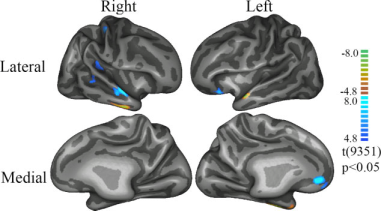

In [33]:
# Para renderizar una imagen en colab

from google.colab.patches import cv2_imshow # for image display
from skimage import io
image = io.imread('/content/papers/imagen1.png')
cv2_imshow(image)

### Enviar archivos adjuntos

Podemos agregar archivos adjuntos como por ejemplo imágenes o PDFs.

Tarea: 
1. Extraer las imagenes de alguno de los papers
2. Enviarlas todas como archivos adjuntos por mail


In [ ]:
#@title Posible solucion

import smtplib
# El módulo imghdr determina el tipo de imagen contenida en un archivo.
import imghdr
from email.message import EmailMessage

msg = EmailMessage()

# Contenido
msg['From']="curso_de_automatizacion_de_humai@gmail.com"
msg['To']="tu_mail@gmail.com"
msg['Subject']= "Probando mandar mails!"
cuerpo_del_mail = 'Te estoy enviando una imagen con Python! =D'
msg.set_content(cuerpo_del_mail)


filelist= [file for file in os.listdir('/content/papers') if file.endswith('.png')]


for i in range(len(filelist)): 
  with open('/content/papers/'+filelist[i], 'rb') as f:
      image_data = f.read()
      # Para saber el tipo de archivo
      image_type = imghdr.what(f.name)
      image_name = f.name

  msg.add_attachment(image_data, maintype='image', subtype=image_type, filename=image_name)

# No se queden en los detalles aquí, pero pueden leer más sobre el protocolo SMTP acá: https://es.wikipedia.org/wiki/Protocolo_para_transferencia_simple_de_correo 
server = smtplib.SMTP('smtp.gmail.com', 587)
server.starttls()

# Usuario y contraseña
usuario = 'tu_mail@gmail.com'
password = 'tu_pass'

server.login(usuario, password)

# enviar
server.send_message(msg)
print('Mail enviado')
server.quit();


## Enviar mails a distintas cuentas de mail guardadas en gsheets
Crear una hoja de calculo con dos columnas ("nombre" y "email") y 3 filas (los datos de 3 personas.

Luego tomar esa informacion de la hoja  de calculo y enviarle los mails saludando a cada persona con el nombre correspondiente (similar al ejercicio mostrado en clase).

In [ ]:
#@title Posible respuesta
### 1. Creo la hoja de calculo
import pandas as pd

df = pd.DataFrame(
    {'Nombre': pd.Series(['persona1', 'persona2', 'persona3']),
     'Mail': pd.Series(['mail1@gmail.com', 'mail2@gmail.com', 'mail3@gmail.com']),
    })


worksheet.update([df.columns.values.tolist()] + df.values.tolist())

### 2. Obtengo nuevamente la informacion en Python
nuestra_hoja = worksheet.get_all_values()
df_aux = pd.DataFrame(nuestra_hoja)
df_aux.columns = df_aux.iloc[0,:]
df_aux = df_aux.iloc[1:,:]
df_aux.head()

### 3. Envio los mails
import smtplib
from email.message import EmailMessage
import time

alumnes = df_aux['Nombre'].to_list()
mails = df_aux['Mail'].to_list()

# Usuario y contraseña
usuario = 'tu_mail@gmail.com'


with smtplib.SMTP('smtp.gmail.com', 587) as server:
  for i in range(len(alumnes)):
    # Contenido
    msg = EmailMessage()

    msg['From']="curso_de_automatizacion_de_humai@gmail.com"
    msg['To']= mails[i]
    msg['Subject']= "Probando mandar mails!"
    cuerpo_del_mail = f'Hola {alumnes[i]}, ¿Todo bien? \n\nSaludos!'
    msg.set_content(cuerpo_del_mail)
    server = smtplib.SMTP('smtp.gmail.com', 587)
    server.starttls()
    server.login(usuario, password)
    # server.starttls()

    # enviar
    server.send_message(msg)
    time.sleep(3)
    print(f'mail enviado a {alumnes[i]}')